In [1]:
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import seaborn as sns
from math import sqrt
import pandas_profiling

import env
import acquire
import prep
import explore_final
import scipy.stats as stats
import matplotlib.pyplot as plt

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import mean_squared_error, r2_score, explained_variance_score
from statsmodels.formula.api import ols

## Initial Hypothesis

Square footage and home value extremes are leading drivers of log error.

## Acquire and summarize data

Initial Dataframe included single family residence homes with 40+ initial fields brought in.

After reviewing the data for missing values, multicollinearity, and low correlation we dropped our data down to 14 columns and 54,000 rows. 300 values were imputed on lotsizesquarefeet with the mean in order to maintain the column.

In [2]:
#nmysql query single family residence from zillow DB
df = prep.prep_df()

In [4]:
df.shape

(55553, 10)

## Data prep and test/train split

Our initial dataframe was split into 70/30 train/test adding a tax_per_sqft field. Random State 123 was used.

In [5]:
#train test split and adding a tax_per_sqft field
train, test = prep.get_train_and_test(df)

In [6]:
train.head(2)

,bathrooms,bedrooms,sqft,tax_value,latitude,longitude,lotsizesquarefeet,yearbuilt,structuretaxvaluedollarcnt,logerror,tax_per_sqft
6397,1.0,3.0,1028.0,360412.0,34043968.0,-118036991.0,5198.0,1953.0,85077.0,0.436997,350.595331
31402,2.5,3.0,1785.0,752431.0,33713809.0,-117788885.0,4248.0,1999.0,230648.0,0.027584,421.529972


In [7]:
X_train, y_train, X_test, y_test = prep.get_baseline_train_test_split(df)

In [8]:
X_train.head(2)

,bathrooms,bedrooms,sqft,tax_value,lotsizesquarefeet,yearbuilt,structuretaxvaluedollarcnt
6397,1.0,3.0,1028.0,360412.0,5198.0,1953.0,85077.0
31402,2.5,3.0,1785.0,752431.0,4248.0,1999.0,230648.0


## Initial exploration and feature selection

In [9]:
#adding a baseline yhat as mean of log error and residual amt based off that.
train['mean_logerror'] = train.logerror.mean()
train['residual'] = train['logerror']- train['mean_logerror']

In [10]:
train.head(2)

,bathrooms,bedrooms,sqft,tax_value,latitude,longitude,lotsizesquarefeet,yearbuilt,structuretaxvaluedollarcnt,logerror,tax_per_sqft,mean_logerror,residual
6397,1.0,3.0,1028.0,360412.0,34043968.0,-118036991.0,5198.0,1953.0,85077.0,0.436997,350.595331,0.017494,0.419503
31402,2.5,3.0,1785.0,752431.0,33713809.0,-117788885.0,4248.0,1999.0,230648.0,0.027584,421.529972,0.017494,0.010090


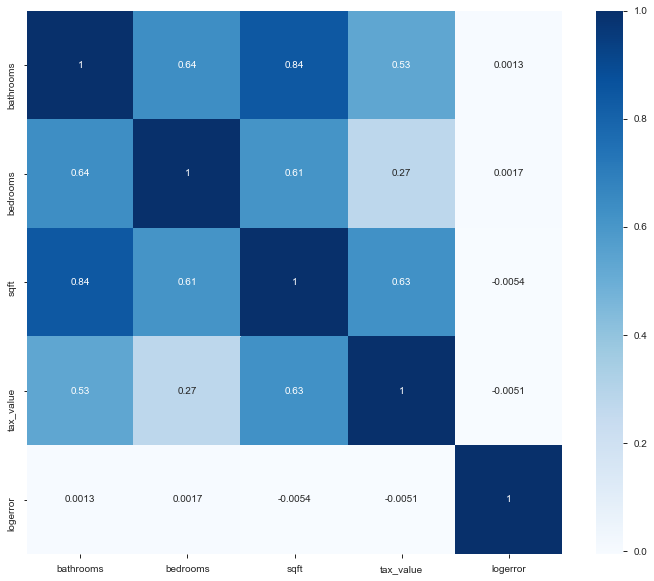

In [11]:
# Heatmap of possible initial features
plt.figure(figsize=(12,10))
subset = train[['bathrooms','bedrooms','sqft','tax_value','logerror']]
cor = subset.corr()
sns.heatmap(cor,annot=True,cmap=plt.cm.Blues)
plt.show()

## Initial Baseline score

In [12]:
baseline = mean_squared_error(train.logerror,train.mean_logerror)
print(baseline)

0.029599455179859777


## MVP

After some basic feature engineering and selection we trained the new model on just sqft and bedrooms. This model performed slightly better than our baseline.

In [13]:
#MSE of sqft and bedrooms as x variables
x = train[['sqft','bedrooms']]
y = train[['logerror']]
ols_model = ols('y ~ x', data=train).fit()
train['yhat'] = ols_model.predict(x)

In [14]:
model1 = mean_squared_error(train.logerror,train.yhat)
print(model1)
model1 < baseline

0.029597398233579056


True

## Exploration

We began our exploration by clustering on the y variable.

   k          sse
0  1  1151.034014
1  2   693.504848
2  3   494.841112
3  4   338.780225
4  5   251.126360
5  6   181.951739
6  7   139.532125
7  8   110.089424
8  9    90.031784


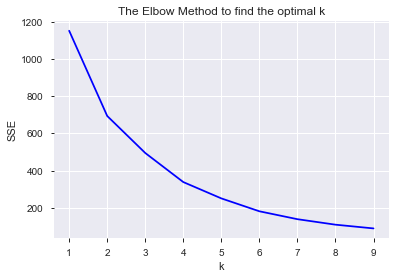

In [15]:
explore_final.elbow_plot(y_train)

In [16]:
#Clustered by logerror. function takes in y_train,X_train, and num_clusters
train = explore_final.target_cluster(y_train,X_train,6)

In [17]:
train.groupby('cluster').mean().sort_values(by='logerror')

,bathrooms,bedrooms,sqft,tax_value,lotsizesquarefeet,yearbuilt,structuretaxvaluedollarcnt,logerror
cluster,,,,,,,,
2,2.246753,3.194805,1950.454545,501475.285714,10110.441558,1957.389610,190422.233766,-1.348334
4,2.231237,3.296017,1871.605870,459025.058700,12286.474671,1960.879245,178168.477007,-0.204170
5,2.251638,3.309586,1862.457127,453512.772788,10011.377517,1961.271039,177118.044944,0.001206
0,2.249828,3.293361,1871.562141,459464.382035,9964.465251,1960.444980,177796.604486,0.159623
3,2.287823,3.381919,1910.518450,459893.918819,11798.631431,1962.243542,186931.804428,0.644718
1,2.187500,3.272727,1740.715909,387158.363636,13675.863636,1956.500000,150418.776777,2.146208


### Target clustering

The crosstab above shows the clusters sorted by lowest average log error to highest. The summary data shows that the largest/most expensive, and smallest/least expensive houses had the largest absolute value logerrors.

Unfortunately...this was due to our clusters being very disproportionate.

In [18]:
train.cluster.value_counts()

5    31442
0     4353
4     2385
3      542
1       88
2       77
Name: cluster, dtype: int64

### Variable clustering



In [21]:
X_train.head(2).T

,6397,31402
bathrooms,1.0,2.5
bedrooms,3.0,3.0
sqft,1028.0,1785.0
tax_value,360412.0,752431.0
lotsizesquarefeet,5198.0,4248.0
yearbuilt,1953.0,1999.0
structuretaxvaluedollarcnt,85077.0,230648.0


In [20]:
X_train = train[['tax_per_sqft','structuretaxvaluedollarcnt','lotsizesquarefeet']]
X_test = test[['tax_per_sqft','structuretaxvaluedollarcnt','lotsizesquarefeet']]

KeyError: "['tax_per_sqft'] not in index"